## Эксперименты к практическому заданию №2 по логистической регресии.

### Accuracy на каждой эпохе будет считаться на отложенной части тренировочной выборки (30 %). Причем внутри обучения ('best_weights' в history) будут сохраняться "лучшие веса" модели - веса, при которых была достигнута наилучшая точность на отложенной части, если  save_best_weights == True, а в противном случае - по ключу 'best_weights' будут лежать веса заключительной эпохи.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy

#### Загрузка данных

In [2]:
train_data = pd.read_csv('data_toxic/toxic_train.csv', index_col=0)
test_data = pd.read_csv('data_toxic/toxic_test.csv', index_col=0)

Text(0.5, 1, 'Распределение классов в трейне')

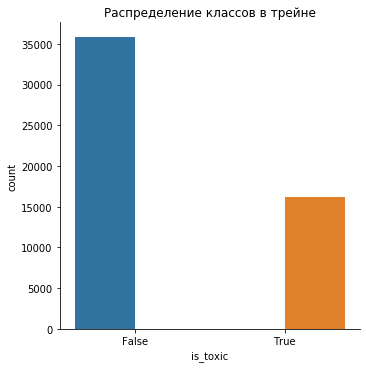

In [3]:
sns.catplot(x='is_toxic', data=train_data, hue='is_toxic', kind='count')
plt.title('Распределение классов в трейне')

In [4]:
target_train = train_data['is_toxic'].map({True : 1, False : -1})
train_data.drop(columns='is_toxic', inplace=True)

### 1. Приводим к нижнему регистру и заменяем все символы, не являющиеся буквами или цифрами на пробелы

In [5]:
train_data_processed_1 = train_data.copy()
test_data_processed_1 = test_data.copy()

In [6]:
import re

def text_process_1(texts_series):
    """
    Takes series with texts
    returns series with preprocessed texts
    (lower register + changed all symbols, which are not letter, number to spaces)
    """
    
    texts_series = texts_series.str.lower()
    texts_series = texts_series.apply(lambda x: re.sub(r'\W', ' ', x))
    return texts_series

In [7]:
train_data_processed_1 = text_process_1(train_data_processed_1['comment_text'])
test_data_processed_1 = text_process_1(test_data_processed_1['comment_text'])

### 2. Пользуемся CountVectorizer

In [8]:
from sklearn.feature_extraction.text import CountVectorizer
countVect = CountVectorizer(min_df=3e-6, lowercase=False)

In [9]:
train_data_processed_2 = countVect.fit_transform(train_data_processed_1)
test_data_processed_2 = countVect.transform(test_data_processed_1)

In [10]:
train_data_processed_2.shape[1]

91839

In [11]:
import optimization
import scipy

Add bias

In [12]:
bias_feature_train = np.ones(train_data.shape[0])
bias_feature_test = np.ones(test_data.shape[0])
bias_feature_train = scipy.sparse.csr_matrix(bias_feature_train).T
bias_feature_test = scipy.sparse.csr_matrix(bias_feature_test).T
train_data_processed_2_with_bias = scipy.sparse.hstack([bias_feature_train, train_data_processed_2], 'csr')
test_data_processed_2_with_bias = scipy.sparse.hstack([bias_feature_test, test_data_processed_2], 'csr')

In [15]:
%%time
def experiment_cycle(train_data, target,
                     step_alpha_list, step_beta_list,
                     w_0_list, batch_size_list, l2_coef=5e-5):
    for step_alpha in step_alpha_list:
        for step_beta in step_beta_list:
            for w_0 in w_0_list:
#                 print(step_alpha)
                clf = optimization.GDClassifier(step_alpha=step_alpha,
                                                step_beta=step_beta,
                                                experiment=True,
                                                l2_coef=l2_coef,
                                                max_iter=1500)
                yield clf.fit(train_data,
                                target,
                                w_0=w_0,
                                trace=True)
                
    for step_alpha in step_alpha_list:
        for step_beta in step_beta_list:
            for w_0 in w_0_list:
                for batch_size in batch_size_list:
                    clf = optimization.SGDClassifier(step_alpha=step_alpha,
                                                     step_beta=step_beta,
                                                     experiment=True,
                                                     max_iter=1500,
                                                     batch_size=batch_size, 
                                                     l2_coef=l2_coef)
                    yield clf.fit(train_data,
                                  target,
                                  w_0=w_0,
                                  trace=True,
                                  log_freq=0.000005)
                    


CPU times: user 4 µs, sys: 1 µs, total: 5 µs
Wall time: 6.91 µs


In [16]:
train_data_processed_2.shape

(52061, 91839)

## ВАЖНО! Все эксперименты будут проводиться с добавлением смещения в веса, которое не будет учитываться в регуляризации (чтобы даже в том случае, когда регуляризация занулит почти все веса, наша разделяющая гиперплоскость не вырождалась в 0)

In [69]:
import tqdm
history_list = []
step_alpha_list = [0.001, 0.01, 0.1, 1, 5, 10, 50]
# step_alpha_list = [0.1]
step_beta_list = [0, 0.001, 0.01, 0.1, 1, 5, 10, 50]
batch_size_list = [1, 64, 128, 1024, 1024 * 4, 1024 * 10, 1024 * 20]
w_0_list = [None]
for history in tqdm.tqdm_notebook(experiment_cycle(train_data_processed_2_with_bias, target_train.values,
                                    step_alpha_list,
                                    step_beta_list,
                                    w_0_list=w_0_list,
                                    batch_size_list=batch_size_list)):
    history_list.append(history)

In [70]:
keys_for_df = ['time', 'func', 'accuracy']

In [71]:
len(history_list[0]['time']), len(history_list[0]['func']), len(history_list[0]['accuracy']),

(1501, 1501, 1501)

In [72]:
history_list[1]['classifier_type'], history_list[30]['step_alpha']

('GD', 1)

In [73]:
{key: history_list[300][key] for key in keys_for_df}

{'time': [0,
  0.4147160053253174,
  0.005410671234130859,
  0.0058765411376953125,
  0.005822658538818359,
  0.005865812301635742,
  0.0059244632720947266,
  0.005861759185791016,
  0.006685495376586914,
  0.004817485809326172,
  0.005803585052490234,
  0.00590825080871582,
  0.005265235900878906,
  0.0061187744140625,
  0.005949735641479492,
  0.006018400192260742,
  0.005877017974853516,
  0.0060465335845947266,
  0.005907535552978516,
  0.005892038345336914,
  0.005887031555175781,
  0.005604267120361328,
  0.00589442253112793,
  0.0059108734130859375,
  0.00591278076171875,
  0.005884408950805664,
  0.006185770034790039,
  0.006029367446899414,
  0.00586390495300293,
  0.005877971649169922,
  0.005938529968261719,
  0.0059087276458740234,
  0.005888700485229492,
  0.005844831466674805,
  0.005854129791259766,
  0.005910634994506836,
  0.005885601043701172,
  0.00608372688293457,
  0.005961894989013672,
  0.005987644195556641,
  0.005915164947509766,
  0.005932807922363281,
  0.005

In [74]:
hist_0_df = pd.DataFrame({key: history_list[29][key] for key in keys_for_df})
hist_1_df = pd.DataFrame({key: history_list[300][key] for key in keys_for_df})

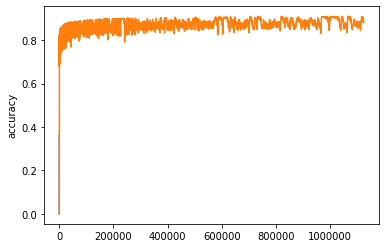

In [75]:
sns.lineplot(x = np.cumsum(np.arange(len(hist_0_df['accuracy']))), y=hist_0_df['accuracy'])
sns.lineplot(x = np.cumsum(np.arange(len(hist_1_df['accuracy']))), y=hist_1_df['accuracy'])
# plt.semilogy()

In [76]:
import pickle
with open('GD_SGD_step_alpha_beta_batch_size.pkl', 'wb') as f:
    pickle.dump(history_list, f)

## Эксперименты с различными начальными приближениями:
https://datascience.stackexchange.com/questions/30989/what-are-the-cases-where-it-is-fine-to-initialize-all-weights-to-zero
###   Рассмотрим 7 экспериментов: 
    1) w_0 = 0
    2) w_0 = uniform(0, 1)
    3) w_0 = uniform(100, 500)
    4) w_0 = uniform(1000, 5000)
    5) w_0 = uniform (10000, 50000)
    6) w_0 = normal with mean = 0, std = 1
    7) w_0 = normal with mean = 0.5, std = 0.5

In [210]:
w_0_list = []
w_0_list.append(np.zeros(train_data_processed_2_with_bias.shape[1]))
w_0_list.append(np.random.uniform(0, 1, size=train_data_processed_2_with_bias.shape[1]))

w_0_list.append(np.random.uniform(100, 500, size=train_data_processed_2_with_bias.shape[1]))
w_0_list.append(np.random.uniform(1000, 5000, size=train_data_processed_2_with_bias.shape[1]))
w_0_list.append(np.random.uniform(10000, 50000, size=train_data_processed_2_with_bias.shape[1]))
w_0_list.append(np.random.normal(0, 1, size=train_data_processed_2_with_bias.shape[1]))
w_0_list.append(np.random.normal(0.5, 0.5, size=train_data_processed_2_with_bias.shape[1]))

In [211]:
train_data_processed_2_with_bias.shape

(52061, 91840)

In [212]:
w_0_list[0].shape

(91840,)

###  Выберем лучшие параметры из прошлого эксперимента:

In [213]:
import pickle 
history_list = []
with open('GD_SGD_step_alpha_beta_batch_size.pkl', 'rb') as f:
    history_list = pickle.load(f)

In [214]:
max_acc = [0, 0]
arg_max = [0, 0]
for i, history in enumerate(history_list):
    if history['classifier_type'] == 'GD':
        if np.max(history['accuracy']) > max_acc[0]:
            max_acc[0] = np.max(history['accuracy'])
            arg_max[0] = i
    else:
        if np.max(history['accuracy']) > max_acc[1]:
            max_acc[1] = np.max(history['accuracy'])
            arg_max[1] = i
    

In [215]:
print(history_list[arg_max[0]]['step_alpha'],
      history_list[arg_max[0]]['step_beta'],
      history_list[arg_max[0]]['classifier_type'],
      max_acc[0])

print(history_list[arg_max[1]]['step_alpha'],
      history_list[arg_max[1]]['step_beta'],
      history_list[arg_max[1]]['classifier_type'],
      max_acc[1])

10 0.001 GD 0.9144631538510788
10 0 SGD 0.9149113259491645


In [216]:
import tqdm
step_alpha_list = [1]
step_beta_list = [0.01]
batch_size_list = [4096]
history_list = []
for history in tqdm.tqdm_notebook(experiment_cycle(train_data_processed_2_with_bias, target_train.values,
                                step_alpha_list,
                                step_beta_list,
                                w_0_list=w_0_list,
                                batch_size_list=batch_size_list)):
    history_list.append(history)

(0.8800179268839234, 0.8373775529803444)

In [217]:
import pickle
with open('GD_SGD_w_0_init.pkl', 'wb') as f:
    pickle.dump(history_list, f)

In [218]:
with open('GD_SGD_w_0_init.pkl', 'rb') as f:
    history_list = pickle.load(f)

In [219]:
max_acc = [0, 0]
arg_max = [0, 0]
for i, history in enumerate(history_list):
    if history['classifier_type'] == 'GD':
        if np.max(history['accuracy']) > max_acc[0]:
            max_acc[0] = np.max(history['accuracy'])
            arg_max[0] = i
    else:
        if np.max(history['accuracy']) > max_acc[1]:
            max_acc[1] = np.max(history['accuracy'])
            arg_max[1] = i
    

In [220]:
print(history_list[arg_max[0]]['step_alpha'],
      history_list[arg_max[0]]['step_beta'],
      history_list[arg_max[0]]['classifier_type'],
      np.cumsum(history_list[arg_max[0]]['time'])[-1],
      max_acc[0],
      arg_max[0] + 1)

print(history_list[arg_max[1]]['step_alpha'],
      history_list[arg_max[1]]['step_beta'],
      history_list[arg_max[1]]['classifier_type'],
      np.cumsum(history_list[arg_max[1]]['time'])[-1],
      max_acc[1],
      arg_max[1] - 6)

1 0.01 GD 3.5905892848968506 0.8800179268839234 1
1 0.01 SGD 2.798290252685547 0.9007618925667457 1


In [173]:
 train_data_processed_2_with_bias.shape

(52061, 91840)

### Простая лемматизация: считаем, что все части слова в тексте - глаголы.

In [61]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /home/paniquex/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [62]:
from nltk.corpus.reader.wordnet import VERB
lemmatizer = nltk.WordNetLemmatizer() 

In [63]:
train_data_processed_1

0         explanation why the edits made under my userna...
1         d aww  he matches this background colour i m s...
2         hey man  i m really not trying to edit war  it...
3           more i can t make any real suggestions on im...
4         you  sir  are my hero  any chance you remember...
                                ...                        
159494        our previous conversation   you fucking sh...
159514                    you are a mischievious pubic hair
159541    your absurd edits   your absurd edits on great...
159546       hey listen don t you ever     delete my edi...
159554    and i m going to keep posting the stuff u dele...
Name: comment_text, Length: 52061, dtype: object

In [114]:
%%time
train_data_processed_lemmatized = train_data_processed_1.apply(lambda x: x.split()).apply(lambda x: [lemmatizer.lemmatize(elem, VERB) for elem in x])
test_data_processed_lemmatized = test_data_processed_1.apply(lambda x: x.split()).apply(lambda x: [lemmatizer.lemmatize(elem, VERB) for elem in x])

CPU times: user 11 s, sys: 7.99 ms, total: 11 s
Wall time: 11 s


In [115]:
train_data_processed_lemmatized

0         [explanation, why, the, edit, make, under, my,...
1         [d, aww, he, match, this, background, colour, ...
2         [hey, man, i, m, really, not, try, to, edit, w...
3         [more, i, can, t, make, any, real, suggestions...
4         [you, sir, be, my, hero, any, chance, you, rem...
                                ...                        
159494    [our, previous, conversation, you, fuck, shit,...
159514              [you, be, a, mischievious, pubic, hair]
159541    [your, absurd, edit, your, absurd, edit, on, g...
159546    [hey, listen, don, t, you, ever, delete, my, e...
159554    [and, i, m, go, to, keep, post, the, stuff, u,...
Name: comment_text, Length: 52061, dtype: object

### Удаление стоп-слов

In [192]:
from nltk.corpus import stopwords
nltk.download('stopwords')
stopwords_set = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/paniquex/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [193]:
%%time
train_data_processed_3 = train_data_processed_lemmatized.apply(lambda x: [elem for elem in x if elem not in stopwords_set])
train_data_processed_3 = train_data_processed_lemmatized.apply(lambda x: ' '.join(x))

test_data_processed_3 = test_data_processed_lemmatized.apply(lambda x: [elem for elem in x if elem not in stopwords_set])
test_data_processed_3 = test_data_processed_lemmatized.apply(lambda x: ' '.join(x))

CPU times: user 481 ms, sys: 15 µs, total: 481 ms
Wall time: 480 ms


In [194]:
%%time
train_data_processed_3 = countVect.fit_transform(train_data_processed_3)
test_data_processed_3 = countVect.transform(test_data_processed_3)

CPU times: user 2.36 s, sys: 29 µs, total: 2.36 s
Wall time: 2.36 s


In [195]:
train_data_processed_3

<52061x83529 sparse matrix of type '<class 'numpy.int64'>'
	with 2020848 stored elements in Compressed Sparse Row format>

Add bias

In [196]:
bias_feature_train = np.ones(train_data.shape[0])
bias_feature_test = np.ones(test_data.shape[0])
bias_feature_train = scipy.sparse.csr_matrix(bias_feature_train).T
bias_feature_test = scipy.sparse.csr_matrix(bias_feature_test).T
train_data_processed_3_with_bias = scipy.sparse.hstack([bias_feature_train, train_data_processed_3], 'csr')
test_data_processed_3_with_bias = scipy.sparse.hstack([bias_feature_test, test_data_processed_3], 'csr')

## Так как лучшими значениями для w_0 оказались:
    1) GD - w_0 = zeros
    2) SGD - w_0 = np.random.uniform(0, 1, size=train_data_processed_2_with_bias.shape[1]), поэтому:

In [197]:
import tqdm
step_alpha_list = [1]
step_beta_list = [0.001]
batch_size_list = [4096]
w_0_list = []
# w_0_list.append(np.zeros(train_data_processed_3_with_bias.shape[1]))
w_0_list.append(np.random.normal(0, 1, size=train_data_processed_3_with_bias.shape[1]))
w_0_list.append(np.random.uniform(0, 1, size=train_data_processed_3_with_bias.shape[1]))

# w_0_list.append(np.random.uniform(100, 500, size=train_data_processed_2_with_bias.shape[1]))
# w_0_list.append(np.random.uniform(1000, 5000, size=train_data_processed_2_with_bias.shape[1]))
# w_0_list.append(np.random.uniform(10000, 50000, size=train_data_processed_2_with_bias.shape[1]))
# w_0_list.append(np.random.normal(0, 1, size=train_data_processed_2_with_bias.shape[1]))
# w_0_list.append(np.random.normal(0.5, 0.5, size=train_data_processed_2_with_bias.shape[1]))
history_list = []
for history in tqdm.tqdm_notebook(experiment_cycle(train_data_processed_3_with_bias, target_train.values,
                                step_alpha_list,
                                step_beta_list,
                                w_0_list=w_0_list,
                                batch_size_list=batch_size_list)):
    history_list.append(history)

In [198]:
max_acc = [0, 0]
arg_max = [0, 0]
for i, history in enumerate(history_list):
    if history['classifier_type'] == 'GD':
        if np.max(history['accuracy']) > max_acc[0]:
            max_acc[0] = np.max(history['accuracy'])
            arg_max[0] = i
    else:
        if np.max(history['accuracy']) > max_acc[1]:
            max_acc[1] = np.max(history['accuracy'])
            arg_max[1] = i
    

In [199]:
print(history_list[arg_max[0]]['step_alpha'],
      history_list[arg_max[0]]['step_beta'],
      history_list[arg_max[0]]['classifier_type'],
      max_acc[0],
      arg_max[0] + 1)

print(history_list[arg_max[1]]['step_alpha'],
      history_list[arg_max[1]]['step_beta'],
      history_list[arg_max[1]]['classifier_type'],
      max_acc[1],
      arg_max[1] - 1)

1 0.001 GD 0.8765605992701198 2
1 0.001 SGD 0.8568410269543505 1


In [82]:
import pickle
with open('GD_SGD_lemmatized_stopwords.pkl', 'wb') as f:
    pickle.dump(history_list, f)

In [174]:
import pickle
with open('GD_SGD_lemmatized_stopwords.pkl', 'rb') as f:
    history_list = pickle.load(f)

In [175]:
max_acc = [0, 0]
arg_max = [0, 0]
for i, history in enumerate(history_list):
    if history['classifier_type'] == 'GD':
        if np.max(history['accuracy']) > max_acc[0]:
            max_acc[0] = np.max(history['accuracy'])
            arg_max[0] = i
    else:
        if np.max(history['accuracy']) > max_acc[1]:
            max_acc[1] = np.max(history['accuracy'])
            arg_max[1] = i
    

In [205]:
print(history_list[arg_max[0]]['step_alpha'],
      history_list[arg_max[0]]['step_beta'],
      history_list[arg_max[0]]['classifier_type'],
      np.cumsum(history_list[arg_max[0]]['time'])[-1],
#       history_list[arg_max[0]]['min_df'],
#       history_list[arg_max[0]]['preprocesser_type'],
#       history_list[arg_max[0]]['train_size'],
      max_acc[0],
      arg_max[0] + 1)

print(history_list[arg_max[1]]['step_alpha'],
      history_list[arg_max[1]]['step_beta'],
      history_list[arg_max[1]]['classifier_type'],
      np.cumsum(history_list[arg_max[1]]['time'])[-1],
#       history_list[arg_max[1]]['min_df'],
#       history_list[arg_max[1]]['preprocesser_type'],
#       history_list[arg_max[1]]['train_size'],
      max_acc[1],
      arg_max[1] - 1)

1 0.001 GD 13.327287912368774 0.8765605992701198 2
1 0.001 SGD 2.5842628479003906 0.8568410269543505 1


## Эксперименты с min_df и max_df
Если мы рассматриваем 0 <= min_df <= 1; 0 <= max_df <= 1, то они связаны формулой: $min\_df + max\_df = 1$, поэтому будем исследовать значение параметра $min\_df$

In [120]:
%%time
import tqdm
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
min_df_list = [1e-6, 2.5e-5, 5e-5, 7.5e-5,
               1e-4, 2.5e-4, 5e-4, 7.5e-4,
               1e-3, 2.5e-3, 5e-3, 7.5e-3]
preprocesser_type_list = ['BOW', 'TFIDF']

preprocesser = None

step_alpha_list = [1]
step_beta_list = [0.001]
batch_size_list = [4096]
history_list = []


for min_df in min_df_list:
    for preprocesser_type in preprocesser_type_list:
        train_data_processed_3 = train_data_processed_lemmatized.apply(lambda x: [elem for elem in x if elem not in stopwords_set])
        train_data_processed_3 = train_data_processed_3.apply(lambda x: ' '.join(x))

    #     test_data_processed_3 = test_data_processed_lemmatized.apply(lambda x: [elem for elem in x if elem not in stopwords_set])
    #     test_data_processed_3 = test_data_processed_3.apply(lambda x: ' '.join(x))

        if preprocesser_type == 'BOW':
            preprocesser = CountVectorizer(min_df=min_df, lowercase=False)
        else:
            preprocesser = TfidfVectorizer(min_df=min_df, lowercase=False)

        train_data_processed_3 = preprocesser.fit_transform(train_data_processed_3)
    #     test_data_processed_3 = preprocesser.transform(test_data_processed_3)

        bias_feature_train = np.ones(train_data.shape[0])
    #     bias_feature_test = np.ones(test_data.shape[0])
        bias_feature_train = scipy.sparse.csr_matrix(bias_feature_train).T
    #     bias_feature_test = scipy.sparse.csr_matrix(bias_feature_test).T
        train_data_processed_3_with_bias = scipy.sparse.hstack([bias_feature_train, train_data_processed_3], 'csr')
    #     test_data_processed_3_with_bias = scipy.sparse.hstack([bias_feature_test, test_data_processed_3])
        w_0_list = []
        w_0_list.append(np.zeros(train_data_processed_3_with_bias.shape[1]))
        w_0_list.append(np.random.normal(0.5, 0.5, size=train_data_processed_3_with_bias.shape[1]))

        for history in tqdm.tqdm_notebook(experiment_cycle(train_data_processed_3_with_bias, target_train.values,
                                    step_alpha_list,
                                    step_beta_list,
                                    w_0_list=w_0_list,
                                    batch_size_list=batch_size_list)):
            
            history['preprocesser_type'] = preprocesser_type
            history['min_df'] = min_df
            history['train_size'] = train_data_processed_3_with_bias.shape[1]
            history_list.append(history)
    
    


CPU times: user 33min 16s, sys: 33 s, total: 33min 49s
Wall time: 7min 31s


In [223]:
import pickle
with open('GD_SGD_bow_tfid_min_df.pkl', 'wb') as f:
    pickle.dump(history_list, f)

In [224]:
import pickle
with open('GD_SGD_bow_tfid_min_df.pkl', 'rb') as f:
    history_list = pickle.load(f)

In [225]:
max_acc = [0, 0]
arg_max = [0, 0]
for i, history in enumerate(history_list):
    if history['classifier_type'] == 'GD':
        if np.max(history['accuracy']) > max_acc[0]:
            max_acc[0] = np.max(history['accuracy'])
            arg_max[0] = i
    else:
        if np.max(history['accuracy']) > max_acc[1]:
            max_acc[1] = np.max(history['accuracy'])
            arg_max[1] = i
    

In [226]:
print(history_list[arg_max[0]]['step_alpha'],
      history_list[arg_max[0]]['step_beta'],
      history_list[arg_max[0]]['classifier_type'],
      history_list[arg_max[0]]['min_df'],
      history_list[arg_max[0]]['preprocesser_type'],
      history_list[arg_max[0]]['train_size'],
      max_acc[0],
      arg_max[0] + 1)

print(history_list[arg_max[1]]['step_alpha'],
      history_list[arg_max[1]]['step_beta'],
      history_list[arg_max[1]]['classifier_type'],
      history_list[arg_max[1]]['min_df'],
      history_list[arg_max[1]]['preprocesser_type'],
      history_list[arg_max[1]]['train_size'],
      max_acc[1],
      arg_max[1] - 1)

1 0.001 GD 1e-06 BOW 83530 0.9017862859337986 1
1 0.001 SGD 2.5e-05 BOW 32272 0.9026826301299699 4


In [191]:
history_list[0]['train_size']

83400

###  Качество упало! (0.900 -> 0.898) Есть предположение, что удаление стоп слов - не самая лучшая идея в данной задаче, так как в них есть такие, как "aren't", "didn't", которые указывают на отрицание. Пример: you aren't nice -> you nice (после удаления стоп слов). Это плохо! Попробуем вернуть стопслова, оставив только лемматизацию.

In [221]:
%%time
import tqdm
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
min_df_list = [1e-6, 2.5e-5, 5e-5, 7.5e-5,
               1e-4, 2.5e-4, 5e-4, 7.5e-4,
               1e-3, 2.5e-3, 5e-3, 7.5e-3]
preprocesser_type_list = ['BOW', 'TFIDF']

preprocesser = None

step_alpha_list = [1]
step_beta_list = [0.001]
batch_size_list = [4096]
history_list = []


for min_df in min_df_list:
    for preprocesser_type in preprocesser_type_list:
        train_data_processed_3 = train_data_processed_lemmatized.apply(lambda x: ' '.join(x))

    #     test_data_processed_3 = test_data_processed_lemmatized.apply(lambda x: [elem for elem in x if elem not in stopwords_set])
    #     test_data_processed_3 = test_data_processed_3.apply(lambda x: ' '.join(x))

        if preprocesser_type == 'BOW':
            preprocesser = CountVectorizer(min_df=min_df, lowercase=False)
        else:
            preprocesser = TfidfVectorizer(min_df=min_df, lowercase=False)

        train_data_processed_3 = preprocesser.fit_transform(train_data_processed_3)
    #     test_data_processed_3 = preprocesser.transform(test_data_processed_3)

        bias_feature_train = np.ones(train_data.shape[0])
    #     bias_feature_test = np.ones(test_data.shape[0])
        bias_feature_train = scipy.sparse.csr_matrix(bias_feature_train).T
    #     bias_feature_test = scipy.sparse.csr_matrix(bias_feature_test).T
        train_data_processed_3_with_bias = scipy.sparse.hstack([bias_feature_train, train_data_processed_3], 'csr')
    #     test_data_processed_3_with_bias = scipy.sparse.hstack([bias_feature_test, test_data_processed_3])
        w_0_list = []
        w_0_list.append(np.zeros(train_data_processed_3_with_bias.shape[1]))
#         w_0_list.append(np.random.normal(0.5, 0.5, size=train_data_processed_3_with_bias.shape[1]))

        for history in tqdm.tqdm_notebook(experiment_cycle(train_data_processed_3_with_bias, target_train.values,
                                    step_alpha_list,
                                    step_beta_list,
                                    w_0_list=w_0_list,
                                    batch_size_list=batch_size_list)):
            
            history['preprocesser_type'] = preprocesser_type
            history['min_df'] = min_df
            history['train_size'] = train_data_processed_3_with_bias.shape[1]
            history_list.append(history)
    
    


CPU times: user 23min 45s, sys: 23.6 s, total: 24min 8s
Wall time: 5min 40s


In [227]:
import pickle
with open('GD_SGD_bow_tfid_min_df_without_stopwords.pkl', 'wb') as f:
    pickle.dump(history_list, f)

In [228]:
import pickle
with open('GD_SGD_bow_tfid_min_df_without_stopwords.pkl', 'rb') as f:
    history_list = pickle.load(f)

In [229]:
max_acc = [0, 0]
arg_max = [0, 0]
for i, history in enumerate(history_list):
    if history['classifier_type'] == 'GD':
        if np.max(history['accuracy']) > max_acc[0]:
            max_acc[0] = np.max(history['accuracy'])
            arg_max[0] = i
    else:
        if np.max(history['accuracy']) > max_acc[1]:
            max_acc[1] = np.max(history['accuracy'])
            arg_max[1] = i
    

In [230]:
print(history_list[arg_max[0]]['step_alpha'],
      history_list[arg_max[0]]['step_beta'],
      history_list[arg_max[0]]['classifier_type'],
      history_list[arg_max[0]]['min_df'],
      history_list[arg_max[0]]['preprocesser_type'],
      max_acc[0])

print(history_list[arg_max[1]]['step_alpha'],
      history_list[arg_max[1]]['step_beta'],
      history_list[arg_max[1]]['classifier_type'],
      history_list[arg_max[1]]['min_df'],
      history_list[arg_max[1]]['preprocesser_type'],
      max_acc[1])

1 0.001 GD 1e-06 BOW 0.9017862859337986
1 0.001 SGD 2.5e-05 BOW 0.9026826301299699


In [165]:
import pickle
with open('GD_SGD_bow_tfid_min_df_without_stopwords.pkl', 'wb') as f:
    pickle.dump(history_list, f)

In [166]:
for history in history_list:
#     if history['classifier_type'] == 'GD':
        print(history['train_size'], np.max(history['accuracy'][-1]), np.cumsum(history['time'])[-1],
               history['preprocesser_type'])

83530 0.901658236762917 13.098536014556885 BOW
83530 0.8777130418080543 0.6543097496032715 BOW
83530 0.8413470772776747 13.160048484802246 TFIDF
83530 0.8370574300531404 2.326728105545044 TFIDF
32272 0.9012100646648313 11.688838958740234 BOW
32272 0.9014021384211537 2.0903093814849854 BOW
32272 0.8465330686983802 11.969154119491577 TFIDF
32272 0.7746974838337922 0.5904834270477295 TFIDF
22324 0.9012100646648313 11.342403411865234 BOW
22324 0.8935271144119342 1.2903671264648438 BOW
22324 0.848261732505282 11.815317153930664 TFIDF
22324 0.848261732505282 2.0619821548461914 TFIDF
17754 0.9011460400793905 11.303791761398315 BOW
17754 0.8782892630770216 0.7551076412200928 BOW
17754 0.8493501504577757 11.666567325592041 TFIDF
17754 0.8483257570907229 2.1028542518615723 TFIDF
13290 0.8993533516870478 9.232459306716919 BOW
13290 0.9017222613483578 1.9566247463226318 BOW
13290 0.8513349126064409 11.217121124267578 TFIDF
13290 0.8418592739612011 1.6114845275878906 TFIDF
7562 0.9008259171521864 1

In [261]:
%%time
import tqdm
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
max_df_list = np.array([1e-3, 2.5e-3, 5e-3, 7.5e-3, 1e-2, 2.5e-3, 5e-3, 7.5e-3, 1e-1, 1.5e-1, 2e-1, 2.5e-1, 3e-1,
                        4e-1, 5e-1, 6e-1, 7e-1, 8e-1, 9e-1, 1])
preprocesser_type_list = ['BOW', 'TFIDF']

preprocesser = None

step_alpha_list = [1]
step_beta_list = [0.001]
batch_size_list = [4096]
history_list = []


for max_df in max_df_list:
    for preprocesser_type in preprocesser_type_list:
        train_data_processed_3 = train_data_processed_lemmatized.apply(lambda x: ' '.join(x))

    #     test_data_processed_3 = test_data_processed_lemmatized.apply(lambda x: [elem for elem in x if elem not in stopwords_set])
    #     test_data_processed_3 = test_data_processed_3.apply(lambda x: ' '.join(x))

        if preprocesser_type == 'BOW':
            preprocesser = CountVectorizer(max_df=max_df, lowercase=False)
        else:
            preprocesser = TfidfVectorizer(max_df=max_df, lowercase=False)

        train_data_processed_3 = preprocesser.fit_transform(train_data_processed_3)
    #     test_data_processed_3 = preprocesser.transform(test_data_processed_3)

        bias_feature_train = np.ones(train_data.shape[0])
    #     bias_feature_test = np.ones(test_data.shape[0])
        bias_feature_train = scipy.sparse.csr_matrix(bias_feature_train).T
    #     bias_feature_test = scipy.sparse.csr_matrix(bias_feature_test).T
        train_data_processed_3_with_bias = scipy.sparse.hstack([bias_feature_train, train_data_processed_3], 'csr')
    #     test_data_processed_3_with_bias = scipy.sparse.hstack([bias_feature_test, test_data_processed_3])
        w_0_list = []
        w_0_list.append(np.zeros(train_data_processed_3_with_bias.shape[1]))
#         w_0_list.append(np.random.normal(0.5, 0.5, size=train_data_processed_3_with_bias.shape[1]))

        for history in tqdm.tqdm_notebook(experiment_cycle(train_data_processed_3_with_bias, target_train.values,
                                    step_alpha_list,
                                    step_beta_list,
                                    w_0_list=w_0_list,
                                    batch_size_list=batch_size_list)):
            
            history['preprocesser_type'] = preprocesser_type
            history['max_df'] = max_df
            history['train_size'] = train_data_processed_3_with_bias.shape[1]
            history_list.append(history)
    
    


CPU times: user 1h 1min 30s, sys: 1min 8s, total: 1h 2min 39s
Wall time: 8min 45s


In [262]:
import pickle
with open('GD_SGD_bow_tfid_max_df_without_stopwords.pkl', 'wb') as f:
    pickle.dump(history_list, f)

In [263]:
for history in history_list:
#     if history['classifier_type'] == 'GD':
    print(history['train_size'], np.max(history['accuracy'][-1]), np.cumsum(history['time'])[-1],
           history['preprocesser_type'])

80344 0.7043344644343428 4.876693964004517 BOW
80344 0.6925539407132338 0.4500272274017334 BOW
80344 0.6889685639285485 4.343837022781372 TFIDF
80344 0.6889685639285485 1.3713643550872803 TFIDF
81854 0.7504321659517255 5.182857513427734 BOW
81854 0.6913374735898585 0.1225430965423584 BOW
81854 0.6895447851975158 5.061573266983032 TFIDF
81854 0.6889685639285485 0.3068068027496338 TFIDF
82540 0.788526794289007 5.6550133228302 BOW
82540 0.7399321339394327 0.41573238372802734 BOW
82540 0.7017094564312696 5.3899266719818115 TFIDF
82540 0.6909533260772136 0.8517513275146484 TFIDF
82821 0.8211793328638197 5.653451204299927 BOW
82821 0.7405723797938408 0.26542091369628906 BOW
82821 0.7171393815225047 5.715137958526611 TFIDF
82821 0.7022856777002369 1.134993076324463 TFIDF
82975 0.8332799795121326 5.768849611282349 BOW
82975 0.8312952173634676 1.4428179264068604 BOW
82975 0.7281516102183239 6.132197856903076 TFIDF
82975 0.7188680453294065 1.4150128364562988 TFIDF
81854 0.7504321659517255 5.1122

### И действительно: качество стало лучше! 0.9027, а до этого было 0.9000.

 ### Заметим еще одну интересную особенность: CountVectorizer работает лучше, чем TF-IDF. Это может быть связано с тем, что TF-IDF сильно штрафует часто встречающиеся слова и отдает приоритет менее встречающимся. Опять же, учитывая специфику нашей задачи, 

In [ ]:
## N_grams for TfidfVectorizer:

In [237]:
%%time
import tqdm
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
min_df_list = [2.5e-5]
max_ngram_range_list = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
preprocesser_type_list = ['TFIDF']

preprocesser = None

step_alpha_list = [1]
step_beta_list = [0.001]
batch_size_list = [4096]
history_list = []


for min_df in min_df_list:
    for max_ngram_range in max_ngram_range_list:
        for preprocesser_type in preprocesser_type_list:
            train_data_processed_3 = train_data_processed_lemmatized.apply(lambda x: ' '.join(x))

        #     test_data_processed_3 = test_data_processed_lemmatized.apply(lambda x: [elem for elem in x if elem not in stopwords_set])
        #     test_data_processed_3 = test_data_processed_3.apply(lambda x: ' '.join(x))

            if preprocesser_type == 'BOW':
                preprocesser = CountVectorizer(min_df=min_df, lowercase=False)
            else:
                preprocesser = TfidfVectorizer(min_df=min_df, lowercase=False, ngram_range=(1, max_ngram_range))

            train_data_processed_3 = preprocesser.fit_transform(train_data_processed_3)
        #     test_data_processed_3 = preprocesser.transform(test_data_processed_3)

            bias_feature_train = np.ones(train_data.shape[0])
        #     bias_feature_test = np.ones(test_data.shape[0])
            bias_feature_train = scipy.sparse.csr_matrix(bias_feature_train).T
        #     bias_feature_test = scipy.sparse.csr_matrix(bias_feature_test).T
            train_data_processed_3_with_bias = scipy.sparse.hstack([bias_feature_train, train_data_processed_3], 'csr')
        #     test_data_processed_3_with_bias = scipy.sparse.hstack([bias_feature_test, test_data_processed_3])
            w_0_list = []
            w_0_list.append(np.zeros(train_data_processed_3_with_bias.shape[1]))
    #         w_0_list.append(np.random.normal(0.5, 0.5, size=train_data_processed_3_with_bias.shape[1]))

            for history in tqdm.tqdm_notebook(experiment_cycle(train_data_processed_3_with_bias, target_train.values,
                                        step_alpha_list,
                                        step_beta_list,
                                        w_0_list=w_0_list,
                                        batch_size_list=batch_size_list)):

                history['preprocesser_type'] = preprocesser_type
                history['min_df'] = min_df
                history['max_ngram_range'] = max_ngram_range
                history['train_size'] = train_data_processed_3_with_bias.shape[1]
                history_list.append(history)




CPU times: user 1h 32min 40s, sys: 2min, total: 1h 34min 41s
Wall time: 18min 23s


In [238]:
import pickle
with open('ngrams_gd_sgd.pkl', 'wb') as f:
    pickle.dump(history_list, f)